# Sentiment Analysis of Amazon's customer reviews
**Authors:** Julián Darío Miranda <br>
**Sources:** *Correlation One* | *Kaggle.com*<br>
**Case presentation time:** 60 minutes

## Introduction to the Case study

**Business Context.** You are a data scientist for a large e-commerce firm. You have tens of thousands of customers writing reviews on products each day. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). The firm wants to quantify customer satisfaction coming from these non-rated interactions to help with further business decisions.

**Business Problem.** Your task is to *build models which can identify the sentiment (positive or negative) of each of these non-rated interactions*.

**Analytical Context.** The data is a set of reviews in CSV file format. We will combine some text processing procedures to be learnt in this session and classification models to develop algorithms capable of classifying interactions by sentiment.

You'll be doing the following in this case:
1. Read and analyze the input text data and the corresponding response variables (ratings)
2. Perform basic pre-processing to prepare the data for modeling
3. Learn and apply various ways of featurizing the reviews text
4. Build machine learning models to classify text as either exhibiting positive or negative sentiment (1 or 0).

## NLP related context

Some of the most famous NLP-related success stories come from Google, where it is used to provide answers to vague or misspelled internet searches, as well as fairly understandable machine translations of plain text.

There are often a lot of misconceptions around the NLP and its place within machine learning in general. NLP is more than just machine learning applied to words. It has two features that make it intractable for common applications like machine learning:

### Challenge 1: Highly Dimensional

Consider the book *One Hundred Years of Solitude*. It has more than 1 million characters. Can we see this as a vector of strings that take values in a space of 1 million dimensions and then apply machine learning methods? This is a very bad idea for two reasons:

1. Basic approaches perform terribly well in such dimensional spaces.
2. These approaches miss some important rules about language that we all know; for example, that "yes", "yeah" and "yayy" mean the same thing.

As a result, a lot of NLP involves finding ways to summarize incredibly long vectors in a concise manner, so that we can explore, analyze, and build models with them later.

### Challenge 2: The text depends on the context (*lexical semantics* )

For example, the word *compact* has many uses in English (*homograph terms* ):

1. A synonym of *small*
2. A verb that describes the action of compressing something
3. A verb that describes the action of making something firm or stable
4. A small case for makeup.
5. A compact car.
6. A cassette.

All-purpose word-processing packages will have to take care of all of this. The ambiguity of some definitions can lead to misleading results that can be easily fixed by a team that is familiar with the underlying NLP processes.

## Importing the packages for data analysis

At first sight, we will use four main packages: ```pandas```,``` numpy```, ```matplotlib``` and ``` seaborn```. Let's import these packages using the keyword ``import``. We will change the name from ``pandas`` to ```pd```,```numpy``` to ```np```,```matplotlib``` to ```plt```and ```seaborn``` to ```sns```, using the keyword ``as``.

We will be using the `nltk`, `sklearn`, `collections` and `wordcloud` packages for processing our text component. While we analyze the text, we will be using `sklearn` package again to model our text features.

In [1]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

We will be working with a .csv file that contains information about tens of thousands of customers writing reviews on Amazon products every day. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). In this way, the following attributes are available in the data:

1. **Id (numerical):** start and end date of the attack in *timestamp* format.
2. **ProductId (categorical):** ID of the referenced product by the customer.
3. **UserId (categorical):** registered user ID.
4. **ProfileName (text):** registered user profile name.
5. **HelpfulnessNumerator (numerical):** number of users who found the review helpful.
6. **HelpfulnessDenominator (numerical):** Number of users who voted whether the review was helpful or not.
7. **Score (ordinal):** rating between 1 and 5.
8. **Time (numerical):** timestamp of the review.
9. **Summary (text):** brief summary of the review.
10. **Text (text):** text of the review.

## Reading and performing basic analysis of the data

As usual the first step is to read the available data and perform some high-level analysis on it. We will be selecting 10000 observations for faster computation:

In [2]:
amazon_reviews = pd.read_csv('Reviews.csv')

## Selecting just 10,000 records for faster computation. 
## Feel free to comment the following line of code later, to build ML models using all the data

amazon_reviews = amazon_reviews[:10000]
amazon_reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Let's look at the distribution of number of words per review. We will do this by applying a *lambda* function that splits each complete review by spaces, which will give us the borad words:

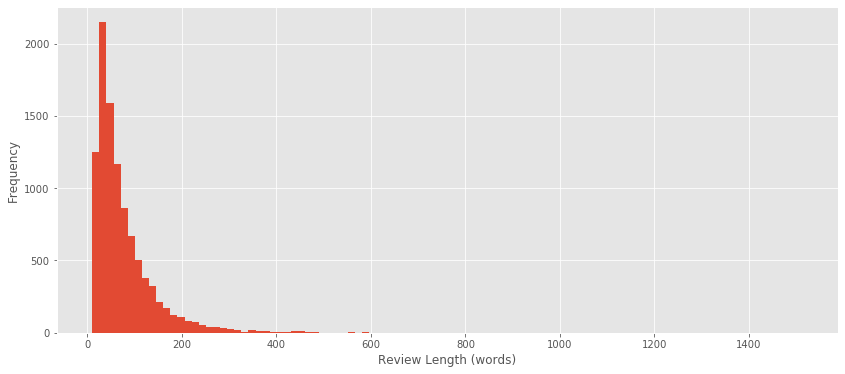

In [3]:
## Getting the number of words by splitting them by a space
words_per_review = amazon_reviews.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [4]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


We can see that the number of words per user review is highly positive skewed with mean of 77, which means that on average, user reviews have 77 words.

Let's also look at the distribution of ratings:

In [5]:
percent_val = 100 * amazon_reviews['Score'].value_counts()/len(amazon_reviews)
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

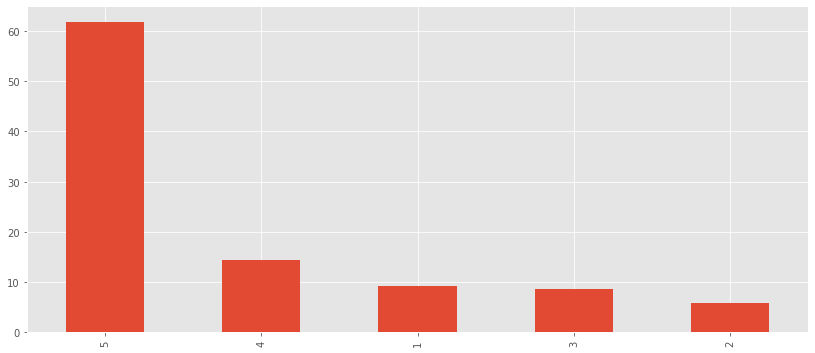

In [6]:
percent_val.plot.bar()
plt.show()

The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s.

### Text visualization using word clouds (*word clouds* )

As visualization is crucial for numerical data, it is also important for text data. However, the text does not lend itself to histogram charts or scatterplots, as numerical data does. In such cases, the **word clouds** are a common and very useful tool to appreciate the text distribution.

To make a word cloud of the string values of the Seires `data['Text']`, we are going to import the `WordCloud` package (if it is not installed, you can proceed to install it with `pip install wordcloud`) and join all the text with the `.join()` method:

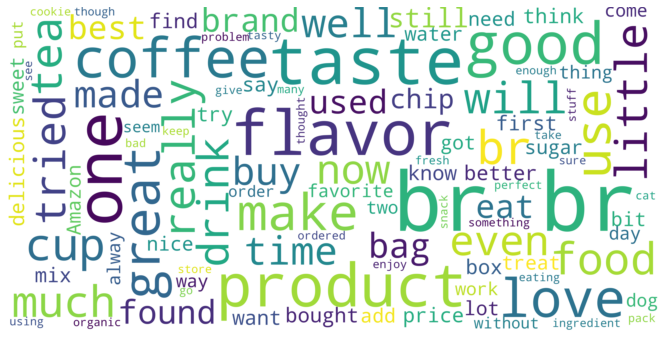

In [7]:
word_cloud_text = ''.join(amazon_reviews['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

The word cloud indicates that many of the reviews talk about food-related things - coffee, flavor, food, taste, drink. We also see some positive words like good, love, best, as well as not desired ones such as br (line break), many (determiner) and something (adverb).

### Standardizing the ratings for sentiment analysis (5 mts)

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule: 
- Ratings of 4 or 5 will get mapped to 1 and will be reltead to positive reviews
- Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews
- Ratings of 3 will get removed since they will represent neutral reviews.

In [8]:
# Mapping the ratings
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3,1,0)

## Removing neutral reviews 
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

# Printing the counts of each class
amazon_reviews['Sentiment_rating'].value_counts()

1    7616
0    1522
Name: Sentiment_rating, dtype: int64

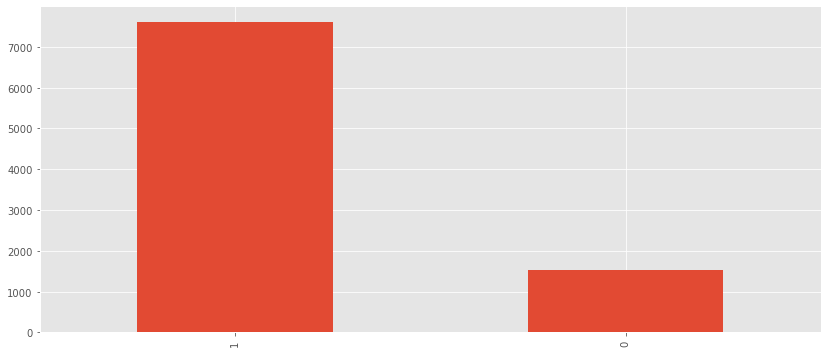

In [9]:
amazon_reviews.Sentiment_rating.value_counts().plot.bar()
plt.show()

There is a class imbalance that we are going to handle by defining robust metrics.

## Pre-processing

As discussed previously, text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization

### 1. Converting words to lower/upper case

Let's start by converting all of the words into a consistent case format, say lowercase:

In [10]:
amazon_reviews['reviews_text_new'] = amazon_reviews['Text'].str.lower()

In the following code cell we analyze the number of unique words that are found in reviews before and after applying this step. This process of extracting individual words is called **word tokenization**, and can be run using the `word_tokenize` function in the `nltk` package:

In [11]:
from nltk import word_tokenize

# Word tokenization example:
word_tokenize("DPhi Bootcamp rules. It is awesome :D")

['DPhi', 'Bootcamp', 'rules', '.', 'It', 'is', 'awesome', ':', 'D']

In [12]:
# For reviews not converted to lowe case
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  27884
Number of unique tokens now:  22852


The number of tokens has gone down by ~18% just from normalizing the corpus.

Removing special characters is a subjective call, especially in cases like this one. People often use special characters to express their emotions and might leave a review like _'This product is the worst!!!'_, while a positive review could be like _'This product is the best. Loved it!'_. Here, the presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them may well not be a good idea.

On the other hand, removing non-emotionally charged punctuation such as commas, periods, and semicolons is likely safe.

### 2. Removing special characters

For the sake of simplicity, we will proceed by removing all of the special characters; however, it pays to keep in mind that this is something to revisit depending on the results we get later. The following gives a list of all the special characters in our dataset:

In [13]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_reviews['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '§',
 '®'}

Let's remove these special characters from the reviews by applying a regular expression:

In [14]:
review_backup = amazon_reviews['reviews_text_new'].copy()
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

Let's decomose the regular expression `[^A-Za-z0-9 ]+`:
- `[ ]`: match any character inside the list defined by the square brackets, including the space character `' '`
- `^`: start of the line
- `A-Z`: accept english upper case characters from A to Z
- `a-z`: accept english lower case characters from a to z
- `0-9`: accept single number characters from 0 to 9

We can see how our reviews change after removing these:

In [15]:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(amazon_reviews['reviews_text_new'][6])

- Old Review -
this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!

- New Review -
this saltwater taffy had great flavors and was very soft and chewy   each candy was individually wrapped well   none of the candies were stuck together  which did happen in the expensive version  fralinger s   would highly recommend this candy   i served it at a beach themed party and everyone loved it 


The number of unique tokens has dropped further:

In [16]:
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  27884
Number of unique tokens now:  18039


### 3. Stopwords and high/low frequency words

As discussed before, stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them. Let's first review what languages are available in the nltk package:

In [17]:
from nltk.corpus import stopwords

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Let's now review the list of English stopwords:

In [18]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Here is an example of removing stopwords:

In [19]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_reviews['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Let's see how we omit these stopwords from our reviews:

In [20]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_reviews['reviews_text_nonstop'] = amazon_reviews['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_reviews[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price there was a wid...,"[great, taffy, great, price, wide, assortment,..."
...,...,...
9995,we switched from the advance similac to the or...,"[switched, advance, similac, organic, product,..."
9996,like the bad reviews say the organic formula ...,"[like, bad, reviews, say, organic, formula, co..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."
9998,i love the fact that i can get this delieved t...,"[love, fact, get, delieved, house, delievy, ch..."


### 4. Stemming & lemmatization

Now we are ready for the last part of our pre-processing - **stemming & lemmatization**.

Different forms of a word often communicate essentially the same meaning. For example, there’s probably no difference in intent between a search for `shoe` and a search for `shoes`. The same word may also appear in different tenses; e.g. "run", "ran", and "running". These syntactic differences between word forms are called **inflections**. In general, we probably want to treat inflections identically when extracting features from the text.

Sometimes this process is nearly-reversible and quite safe (e.g. replacing verbs with their infinitive, so that "run", "runs", and "running" all become "run"). Other times it is a bit dangerous and context-dependant (e.g. replacing superlatives with their base form, so that "good", "better", and "best" all become "good"). The more aggressive you are, the greater the potential rewards and risks. For a very aggressive example, you might choose to replace "Zeus" and "Jupiter" with "Zeus" only; this might be OK if you are summarizing myths, confusing if you are working on astronomy, and disastrous if you are working on comparative mythology.

We won't get into the details of the differences between stemming, lemmatization and other types of text normalization here. Please review the following resource for detailed explanation: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.

**Stemming** works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [21]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


It can be seen that we get a meaning root word from Lemmatizer while Stemmer just cuts out and extracts the first important part of the word.

## Building a machine learning model

Now we have cleaned-up versions of two very important pieces of data – the actual review text and its corresponding sentiment rating:

In [23]:
amazon_reviews[['Text','Score','Sentiment_rating']].head(5)

,Text,Score,Sentiment_rating
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


The independent variables or model features are derived from the review text. Previously, we discussed how we can use n-grams to create features, and specifically how bag-of-words is the simplest interpretation of these n-grams, disregarding order and context entirely and only focusing on frequency/count. Let's use that as a starting point.

Conversely, reading each of the reviews, it is clear that, for instance, "good" is mentioned in context like "not as good" or "sounds good". This indicates that in the world of text we cannot go by single words (also called **1-grams**) alone. The context of the sentence or the surrounding words at least are very much necessary to understand the sentiment of a sentence.

## n-grams

Since 1-grams are sometimes insufficient to understand the significance of certain words in our text, it is natural to consider blocks of words, or **n-grams**.

The simplest version of the n-gram model, for $n > 1$, is the **bigram** model, which looks at pairs of consecutive words. For example, the sentence "The quick brown fox jumps over the lazy dog" would have tokens "the quick", "quick brown",..., "lazy dog". The following image (source: http://recognize-speech.com/language-model/n-gram-model/comparison) explains this concept:

![](ngrams.png)

This has obvious advantages and disadvantages over looking at words individually:

- **Advantages:**
    1. Retains the structure of the overall document, and
    2. Paves the way for analyzing words in context
<br></br><br></br>
- **Disadvantages:**
    1. The dimension is vastly larger

In practice, this last challenge can be truly daunting. As an example, *War and Peace* has 3 million characters, which translates to several hundred thousand 1-grams (words). If you consider that the set of all possible bigrams can be as large as the square of the number of 1-grams, this gets us to a **hundred billion possible bigrams!** If classical ML techniques are not suitable for training on 3 million characters, how can they possibly deal with a hundred billion dimensions?

For this reason, it is often prudent to start by extracting as much value out of 1-grams as possible, before working our way up to more complex structures.

Let's look at an example of extracting n-grams over a proposed sentence:

In [24]:
from nltk import ngrams

sentence = 'A bird in the hand worths two in the bush'

for n in range(1, 6):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)))

1-grams:
 [('A',), ('bird',), ('in',), ('the',), ('hand',), ('worths',), ('two',), ('in',), ('the',), ('bush',)]
2-grams:
 [('A', 'bird'), ('bird', 'in'), ('in', 'the'), ('the', 'hand'), ('hand', 'worths'), ('worths', 'two'), ('two', 'in'), ('in', 'the'), ('the', 'bush')]
3-grams:
 [('A', 'bird', 'in'), ('bird', 'in', 'the'), ('in', 'the', 'hand'), ('the', 'hand', 'worths'), ('hand', 'worths', 'two'), ('worths', 'two', 'in'), ('two', 'in', 'the'), ('in', 'the', 'bush')]
4-grams:
 [('A', 'bird', 'in', 'the'), ('bird', 'in', 'the', 'hand'), ('in', 'the', 'hand', 'worths'), ('the', 'hand', 'worths', 'two'), ('hand', 'worths', 'two', 'in'), ('worths', 'two', 'in', 'the'), ('two', 'in', 'the', 'bush')]
5-grams:
 [('A', 'bird', 'in', 'the', 'hand'), ('bird', 'in', 'the', 'hand', 'worths'), ('in', 'the', 'hand', 'worths', 'two'), ('the', 'hand', 'worths', 'two', 'in'), ('hand', 'worths', 'two', 'in', 'the'), ('worths', 'two', 'in', 'the', 'bush')]


### Bag-of-words

The bag-of-words procedure falls under a broader category of techniques known as **count-based representations**. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

Let's start with 1-grams (words). The simplest type of information would be whether a particular word occurs in particular documents. This leads to **word-document co-occurrence matrices**, where the $(W, X)$ entry of the word-document matrix is set to 1 if word $W$ occurs in document $X$, and 0 otherwise.

Let's create a word-document co-occurrence matrix for our set of reviews using the `CountVectorizer` class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization:

In [25]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(amazon_reviews['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,...,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's use this to create a bag of words from the reviews, excluding the noise words we identified earlier:

In [26]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [27]:
bow_data

<9138x18039 sparse matrix of type '<class 'numpy.int64'>'
	with 493450 stored elements in Compressed Sparse Row format>

We can see that a sparse matrix of 9138 observations (number of rows of the `reviews_text_new` series) has been built, and 17679 columns corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews.

Once the bag of words is prepared, the dataset should be divided into training and test sets:

In [28]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    amazon_reviews['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [29]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.847921
0    0.152079
Name: Sentiment_rating, dtype: float64

The test data contains 84% positive sentiment reviews. So, if we were to naively classify all reviews as positive, then our model would achieve an accuracy of 84%. Therefore, this is the baseline that any model we create must beat. We have an imbalance in the classes. However, we will skip the handling class imbalance processes to focus on NLP modeling. However, as an intermediate step, techniques such as SMOTE, sub-sampling or oversampling can be applied.

### Applying logistic regression

Let's train the model on our training data and run the resulting model on our test data:

In [30]:
### Training the model 
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.9533248081841433


Let's modify the set of features in the model to include bigrams, trigrams, and 4-grams:

In [31]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

In [32]:
# Notice the increase in features with inclusion of n-grams
bow_data

<9138x1261413 sparse matrix of type '<class 'numpy.int64'>'
	with 2530528 stored elements in Compressed Sparse Row format>

In [33]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    amazon_reviews['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [34]:
# Defining and training the model
lr_model_all_new = LogisticRegression(max_iter = 200)
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 score:  0.9541745134965474


The F1-score has jumped slightly. This is an example of what simple hyperparameter tuning and input feature modification can do to the overall performance. We can even get interpretable features from this in terms of what contributed the most to positive and negative sentiment:

In [35]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

,words,weights
448809,great,1.327899
305794,delicious,0.952278
810997,perfect,0.838283
438773,good,0.831941
1023733,the best,0.820474
358331,excellent,0.820415
171393,best,0.792800
639088,love,0.783770
709971,nice,0.769319
930961,smooth,0.637428


In [36]:
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

,words,weights
1241695,worst,-0.542726
1175374,very disappointed,-0.558064
1206112,were,-0.564802
874505,return,-0.568145
143979,away,-0.573367
959625,stick,-0.585487
144964,awful,-0.593925
1193585,waste,-0.612399
317336,disappointing,-0.613680
982546,t,-0.674800


## TF-IDF model

Of course, bag-of-words are not the only way to featurize text. Another method is the **Term Frequency-Inverse Document Frequency (TF-IDF)** method. This evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The TF-IDF weight is the product of two terms. The first computes the normalized Term Frequency (TF); i.e. the number of times a word appears in a document divided by the total number of words in that document. The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears:

<img src='tf-idf.png'>

Let's re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets:

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [38]:
tfidf_data

<9138x18039 sparse matrix of type '<class 'numpy.float64'>'
	with 493450 stored elements in Compressed Sparse Row format>

In [39]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            amazon_reviews['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

### Applying logistic regression to TF-IDF features

Let's apply logistic regression to the features created from TF-IDF:

In [40]:
### Setting up the model class
lr_model_tf_idf = LogisticRegression()

## Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.9396341463414635


Here we have decresed slightly our F1 score value with TF-IDF as compared to the bag-of-words approach.

## Word embeddings model

The final type of featurization we will cover are **word embeddings**. This is a type of word representation that allows words with similar meaning to have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems. It is capable of capturing the context of a word in a document, its semantic and syntactic similarity, and its relation with other words. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space.

In the following image, each of the words have been represented in 2-dimensions for simplicity. It can be clearly seen that words with similar context are grouped together – bathroom, kitchen, bathtub are grouped together, while microwave, refrigerator, oven form another group, etc.

In [41]:
from IPython.display import Image
from IPython.core.display import HTML

<img src='wembeddings.png'>
Image source: https://medium.com/@rohit_agrawal/using-fine-tuned-gensim-word2vec-embeddings-with-torchtext-and-pytorch-17eea2883cd 

There are different methods to learn word embeddings, such as Word2Vec, GloVe, FastText, spectral embedding, and UMAP, among others:
- **Word2Vec:** uses a shallow Neural Network.
- **GloVe:** is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 
- **FastText:** is a library for learning of word embeddings and text classification created by Facebook's AI Research lab.
- **Spectral embedding:** is a dimensionality reduction technique that forms a affinity matrix applying a spectral decomposition.
- **UMAP:** the Uniform Manifold Approximation and Projection is a dimension reduction technique used for general non-linear dimension reduction procedures.

### Why use word embeddings over bag-of-words and TF-IDF?

Each word is represented by a real-valued vector, which generally has tens or hundreds of dimensions. This is in contrast to he thousands or millions of dimensions required for sparse word representations. Thus, word embeddings can drastically reduce the number of dimensions required for representing a text document:

In [42]:
import gensim

In [43]:
### Loading a pre-trained glove word embedding that is trained on twitter dataset 
### This word embedding is 200 dimensional in lenght (200 features per term)
### Source: https://nlp.stanford.edu/projects/glove/

model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(
        os.getcwd(), 
        'Twitter_Glove_pretrained.txt'),
    binary=False,
    unicode_errors='ignore')

To generate a model like the one we are importing, you can uncomment and execute the following commented code cell (be aware of the computational expense that the instructions might take (>2h processing)):

In [44]:
# from gensim.models.fasttext import FastText

# # Set values for various parameters
# feature_size = 200   # Word vector dimensionality  
# min_word_count = 1   # Minimum word count                        
# sample = 1e-3        # Downsample setting for frequent words
# iter = 5000          # Represents the number of epochs

# tokenized_corpus = [nltk.word_tokenize(doc) for doc in amazon_reviews['reviews_text_new']]
# ft_model = FastText(tokenized_corpus, size=feature_size, 
#                      min_count = min_word_count, sample=sample, 
#                      iter=5000)

# ft_model.save_model("model_filename.bin") # Saving the model
# model = fasttext.load_model("model_filename.bin") # Loading the model

We had approximately 18,000 distinct tokens for 1-gram features in the bag-of-words representation, yet will only have 200 dimensions in this word embedding. This is a huge difference! Moreover, word embeddings capture the context and semantics of the sentences since each word vector representation is itself based on its contextual meaning.

Below is the vector representation for "food" and "great":

In [45]:
print("The embedding for food is", len(model['food']), "dimensional")
model['food']

The embedding for food is 200 dimensional


array([-6.9175e-01, -1.4259e-01,  3.8653e-01, -2.3141e-01, -2.0408e-01,
       -2.1565e-01,  7.7839e-01,  2.2689e-03, -7.2446e-02, -6.0134e-01,
       -4.2400e-01, -5.7140e-01, -8.4249e-01,  1.5947e-01, -1.2899e-01,
        5.9032e-01, -1.3632e-01, -6.6478e-01, -1.9557e-01, -8.2453e-01,
       -1.3177e-01,  1.3514e-01, -7.3214e-01,  4.8200e-01,  4.3505e-01,
        1.6676e+00, -1.8275e-01, -1.0007e-01,  3.7003e-01,  1.0411e-01,
       -8.8115e-01, -9.7733e-04, -2.9459e-01, -7.3869e-02, -4.0103e-01,
       -4.6626e-01,  2.3253e-01,  2.7776e-01,  4.0754e-01, -4.5051e-02,
       -1.9468e-01, -2.9230e-01, -3.4642e-01, -4.9286e-01,  1.0467e-01,
        7.2143e-01,  5.9596e-01,  5.3495e-01,  3.8788e-02, -1.4406e-01,
       -5.2248e-02, -6.8292e-01, -1.0080e-01, -1.2961e-01, -2.6006e-02,
        1.4836e-01,  3.2417e-02,  1.3997e-01,  8.3943e-03, -2.3139e-01,
       -1.8000e-01, -3.1689e-01,  2.3606e-01,  1.8237e-01,  4.3933e-01,
       -3.2313e-01, -2.1512e-03, -4.4172e-01,  4.1011e-01,  1.71

In [46]:
print("The embedding for great is", len(model['great']), "dimensional")
model['great']

The embedding for great is 200 dimensional


array([ 1.0751e-01,  1.5958e-01,  1.3332e-01,  1.6642e-01, -3.2737e-02,
        1.7592e-01,  7.2395e-01,  1.1713e-01, -3.5036e-01, -4.2937e-01,
       -4.0925e-01, -2.5761e-01, -1.0264e+00, -1.0014e-01,  5.5390e-02,
        2.0413e-01,  1.2807e-01, -2.6337e-02, -6.9719e-02, -3.6193e-02,
       -1.9917e-01,  3.9437e-02, -9.2358e-02,  2.6981e-01, -2.0951e-01,
        1.5455e+00, -2.8123e-01,  3.2046e-01,  4.5545e-01, -3.8841e-02,
       -1.7369e-01, -2.3251e-01, -5.9551e-02,  2.3250e-01,  4.4214e-01,
        3.3666e-01,  3.9352e-02, -1.2462e-01, -2.9317e-01, -4.8857e-02,
        6.9021e-01,  7.1279e-02,  1.0252e-01,  1.6122e-01, -2.3536e-01,
        6.2724e-02,  2.0222e-01,  5.0234e-02, -1.1611e-01,  2.8909e-02,
       -1.1109e-01, -5.0241e-02, -5.9063e-01, -8.8747e-02,  5.1444e-01,
       -1.3715e-01,  1.7194e-01, -8.3657e-02,  9.6333e-02, -9.7063e-02,
        3.4003e-03, -7.0180e-02, -5.9588e-01, -2.8264e-01,  1.2529e-01,
        2.4359e-01, -4.9082e-01, -4.2533e-02,  2.2158e-01, -2.14

To find the vector for an entire review, we get the vector for each word in the review separately and take a simple average.

Let's calculate the vector for every single review in the dataset:

In [47]:
# List for adding each average rperesentation per observation
review_embeddings = []

## Review_average
Review_average = np.zeros(model.vector_size)

# For each review in the review's dataset
for each_review in amazon_reviews['reviews_text_new']:
    
    count_val = 0
    
    # For each worn in the review
    for each_word in word_tokenize(each_review):     
        if(each_word.lower() in model):
            Review_average += model[each_word.lower()]
            count_val += 1
    
    review_embeddings.append(list(Review_average/count_val))

Let's convert the list of vector representations for each review into a DataFrame and split it into train and test sets:

In [48]:
# Converting to a DataFrame object
embedding_data = pd.DataFrame(review_embeddings)

# Filling null values
# Null values are the ones that the Twitter pre-trained model is not considering (few of them)
embedding_data = embedding_data.fillna(0)
embedding_data

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.017031,0.073933,0.044372,0.345686,-0.054879,0.128388,0.516738,-0.051841,-0.170889,-0.215053,...,-0.148464,0.069972,0.180464,0.072243,0.058429,-0.042165,0.102130,0.102651,-0.027328,0.045897
1,0.004867,0.234855,0.081459,0.800303,-0.175189,0.491553,1.240453,-0.123022,-0.152865,-0.495640,...,-0.294793,0.156971,0.302243,0.136332,0.077925,-0.178687,0.319638,0.329597,-0.010736,-0.045276
2,0.054898,0.121937,0.086319,0.452975,-0.100278,0.330602,0.828519,-0.135867,-0.220501,-0.445102,...,-0.252651,0.168930,0.193142,0.118796,0.071619,-0.202528,0.298770,0.185984,-0.064427,-0.042747
3,0.121080,0.415778,0.208763,1.150782,-0.285192,0.832986,2.195385,-0.337402,-0.621329,-1.226587,...,-0.687255,0.431361,0.537418,0.322497,0.098490,-0.426390,0.690071,0.534326,-0.124685,-0.199035
4,0.197436,0.701286,0.429690,1.899491,-0.479943,1.313881,3.710398,-0.582405,-1.249420,-2.059263,...,-1.146727,0.863788,1.067669,0.384649,0.358384,-0.715020,1.157039,0.889476,-0.126488,-0.355712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9133,-46.262026,549.113219,411.154716,1384.951148,-468.010915,1175.151251,4166.656854,-684.511448,-969.302577,-1631.833533,...,-1119.288914,548.180227,803.262467,72.233662,151.366317,-527.599798,992.601517,1216.900516,-151.632963,-82.007893
9134,-40.695678,482.963213,361.680872,1218.239158,-411.665424,1033.726995,3665.057244,-602.113941,-852.594775,-1435.428782,...,-984.518924,482.161553,706.629380,63.624305,133.097164,-464.049121,873.125890,1070.432422,-133.306181,-72.186908
9135,-19.798611,235.852405,176.647535,594.976721,-201.029682,504.821211,1789.863001,-294.001505,-416.384191,-701.022258,...,-480.786358,235.451227,345.113985,31.071044,64.990887,-226.635431,426.379239,522.786156,-65.121339,-35.257320
9136,-146.306978,1743.480751,1305.778995,4397.761539,-1485.894361,3731.462010,13229.850786,-2173.108542,-3077.622440,-5181.587794,...,-3553.801068,1740.283367,2550.932181,229.512778,480.259064,-1675.204836,3151.599401,3864.226200,-481.566499,-260.574083


In [49]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(embedding_data,
                                                                            amazon_reviews['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

Let's now apply logistic regression to our word embeddings representation:

In [50]:
lr_model_all.fit(X_train_embed, y_train_embed)
test_pred_lr_all = lr_model_all.predict(X_test_embed)

print("F1 score: ",f1_score(y_test_embed, test_pred_lr_all))

F1 score:  0.9177027827116636


Unfortunately, this is not as good as either the bag-of-words or TF-IDF representations. Furthermore, although word embeddings was really effective at reducing the overall number of dimensions, it suffers from the problem of interpretability. This means that it is very hard for us to even diagnose what is causing its sub-par performance.

In our case, creating features using TF-IDF got us an accuracy of 92% with very interpretable features. This is a good combination and so we deem this the best model for us here.

## Conclusions

In this case, we cleaned up and featurized an Amazon reviews dataset and built some classification models on these featurizations to predict sentiment. We saw that bag-of-words and TF-IDF both gave interpretable features, while word embeddings did not really. Through increase the set of n-grams we used from 1-grams to up to 4-grams, we were able to get our logistic regression model accuracy up to 95%.

Building machine learning models on text is a very involved discipline. Some important things of note are as follows:

1. Although there are different types of pre-processing involved in textual data, **not everything has to be applied in each case**. For instance, when dealing with text messages special characters might represent important information and need not be removed. Furthermore, upper case may mean someone is angry and represents shouting, so case may not need to be normalized either.

2. Hyperparameter tuning in machine learning models is a very important step. We can't go ahead training a model with default parameters. Different sets of parameters have to be tried to see what contributes to the best model.

3. Every NLP classification task is different, but the process to be followed is similar to what we did in this case: wrangle the data → create features from text → train ML models.